<a href="https://colab.research.google.com/github/andreacangiani/NSPDE-ANA2023/blob/main/Python/C5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Finite Element Method in 1D

1. Linear ($k=1$) Finite Element Method solver for the 1D Poisson problem:

$-u''=f \quad \in \Omega=(a,b)^2$

$u(a)=0=u(b)$

Import usual modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
from scipy.sparse.linalg import spsolve
from scipy.sparse.linalg import eigsh

FEM system assembly with trapezoidal rule for rhs

In [21]:
def FEM1_1D_TRAP(omega,N,rhs):
  # 1D FEM with k=1 system matrix and rhs for
  # diffusion problem with homogeneous Dirichlet bc
  # trapezoidal rule uniform grid

  # grid is defined here as uni
  h = (omega[1]-omega[0])/N
  vertices = np.linspace(omega[0],omega[1],N+1)

  # initialise system
  A = sp.lil_matrix((N+1,N+1)) ## lil is much more efficient when writing wrt csr
  F = np.zeros(N+1)

  # Assembly loop
  for i in range(0,N):
    # local contributions
    A_ele = np.matrix([[1/h, -1/h],[-1/h,1/h]]) ## small 2x2 matrix 
    F_ele = 0.5 * h * rhs(vertices[i:i+2]) ## small 2 vector 
    ## we now need to distribute those in the big matrix 

    #assembly local-to-global
    A[i:i+2,i:i+2] += A_ele
    F[i:i+2] += F_ele
  
  # Apply boundary conditions
  A[0,0] = 1/h; A[0,1] = 0; F[0] = 0  ## good for conditioning to set A[0,0] = 1/h
  A[N,N] = 1/h; A[N,N-1] = 0; F[N] = 0

  # return system matrix and rhs vector
  return A, F

Define FEM problem and solve

0.03191592653460351


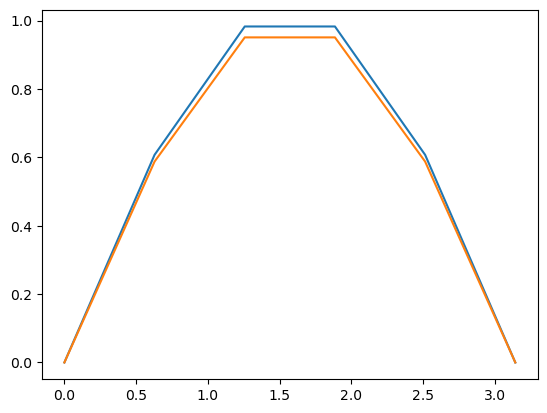

In [29]:

omega = [0,np.pi]
rhs = lambda x: np.sin(x)
exact = lambda x: np.sin(x)

N=5; 
n_qpoints = 3

# call function computing FEM system
A,F = FEM1_1D_TRAP(omega,N,rhs)

# solve
A = A.tocsr() ## csr format is much faster in solving
Uh = spsolve(A,F)

# Evaluate exact solution at grid nodes
x = np.linspace(omega[0],omega[1],N+1)
U = exact(x)

# Plot solutions
plt.plot(x,Uh)
plt.plot(x,U)

# compute discrete max norm error 
print(np.max(np.abs(U-Uh)))

In [30]:
print(A.todense(),F)

[[ 1.59154943  0.          0.          0.          0.          0.        ]
 [-1.59154943  3.18309886 -1.59154943  0.          0.          0.        ]
 [ 0.         -1.59154943  3.18309886 -1.59154943  0.          0.        ]
 [ 0.          0.         -1.59154943  3.18309886 -1.59154943  0.        ]
 [ 0.          0.          0.         -1.59154943  3.18309886 -1.59154943]
 [ 0.          0.          0.          0.          0.          1.59154943]] [0.         0.36931637 0.59756643 0.59756643 0.36931637 0.        ]


2. Repeat exercise but for the non-homogeneous Dirichlet conditions, so:

$-u''=f \quad \in \Omega=(a,b)^2$

$u(a)=g(a)$ and $u(b)=g(b)$

for $g$ a given function.

Also:
- allow for nonuniform grid
- use reference element to assemble 
- to compute the rhs, use arbitrary order Gauss integration

In [2]:
# Gauss quadrature formula on [0,1]
def quadrature(n_quadrature_points):

  # exploit numpy Gauss quadrature. This is defined in [-1,1]
  q, w = np.polynomial.legendre.leggauss(n_quadrature_points)

  return (q+1)/2, w/2

Function defining the mesh

In [3]:
def mesh(omega,N):
  return np.linspace(omega[0],omega[1],N+1)

Define reference element transformation of coordinates

In [4]:
# Transformation of coordinates functions:
# reference element -> current element
# [0,1] -> [q[i], q[i+1]]

def mapping(q, i):
    # check index is within range
    assert i < len(q)-1
    assert i >= 0
    return lambda x: q[i]+x*(q[i+1]-q[i])


def mapping_J(q,i):
    assert i < len(q)-1
    assert i >= 0
    return q[i+1]-q[i]


# Linear lagrange basis on reference element
def basis1(i):
    assert i < 2
    assert i >= 0
    if i == 0:
        phi = lambda x: 1-x
    else:
        phi = lambda x: x
    return phi


# Linear lagrange basis derivatives on reference element
def basis1_derivative(i):
    assert i < 2
    assert i >= 0
    if i == 0:
        dphi = lambda x: -np.ones(len(x))
    else:
        dphi = lambda x: np.ones(len(x))
    return dphi


FEM system assembly with Gauss integration



In [59]:
def FEM1_1D_GAUSS(omega,N,n_qpoints,rhs):
  # 1D FEM with k=1 system matrix and rhs

  # grid
  vertices = mesh(omega,N)

  # quadrature formula on reference element
  q,w = quadrature(n_qpoints)

  # Evaluation of linear Lagrange basis 
  phi = [basis1(0)(q),basis1(1)(q)]
  dphi = [basis1_derivative(0)(q),basis1_derivative(1)(q)]

  # rhs 
  rhs_v = np.zeros((N,n_qpoints))
  for i in range(N):
    rhs_v[i,:] = rhs(mapping(vertices,i)(q))

  # initialise system
  A = sp.lil_matrix((N+1,N+1))
  F = np.zeros(N+1)

  # Assembly loop
  for i in range(N):
    # single contributions
    a00 = np.dot(w,dphi[0]*dphi[0])
    a01 = np.dot(w,dphi[0]*dphi[1])
    a10 = np.dot(w,dphi[1]*dphi[0])
    a11 = np.dot(w,dphi[1]*dphi[1])
    A_elem = np.matrix([[a00,a01],[a10,a11]])
    F_elem = np.array([np.dot(w,rhs_v[i,:]*phi[0]*mapping_J(vertices,i)**2),np.dot(w,rhs_v[i,:]*phi[1]*mapping_J(vertices,i)**2)])

    A[i:i+2,i:i+2] += A_elem
    F[i:i+2] += F_elem
    

  # return system matrix and rhs vector
  return A, F

Function implementing the boundary (nonhomogeneous) Dirichlet conditions. (Similar to FD code, but boundary condition given by sunction $g$!)

In [60]:
def apply_boundary_conditions(omega,N, A, F, g):
    A[0,0] = 1; A[0,1] = 0; F[0] = g(omega[0])
    A[N,N] = 1; A[N,N-1] = 0; F[N] = g(omega[1])

Define FEM problem and solve

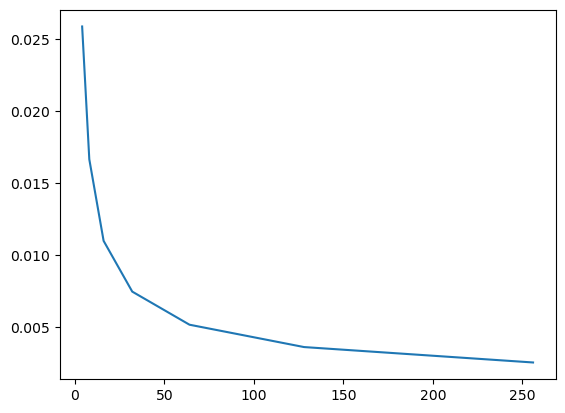

In [151]:
omega = [0,1]
rhs = lambda x: np.sin(x)
sol = lambda x: np.sin(x)

# Initialise error vector
Err = np.zeros(7)
NN = np.zeros(7)
Cond = np.zeros(7)


for i in range(7):
  N = 2**(i+2)
  NN[i] = N
  n_qpoints = 1
  vertices = mesh(omega,N)

  # call function computing FEM system
  A,F = FEM1_1D_GAUSS(omega,N,n_qpoints,rhs)
  apply_boundary_conditions(omega,N,A,F,rhs)
  A = A.tocsr()

  # solve
  U = spsolve(A,F)

  #condition number of Stiffness matrix
  #Cond[i] = eigsh(A,k=N,which='LM',return_eigenvectors=False)[-1]/eigsh(A,k=N,which='SM',return_eigenvectors=False)[-1]
  Cond[i] = np.linalg.cond(A.todense())

  # Evaluate exact solution at grid nodes
  U_ex = sol(vertices)

  # Compute errors 
  #Err[i] = np.max(np.abs(U-U_ex))
  Err[i] = FEM1_H1(omega,N,U,sol)

# Plot error
plt.plot(NN,Err)

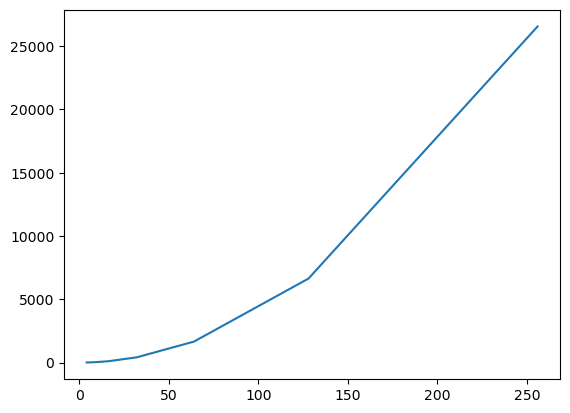

In [152]:
plt.plot(NN,Cond)

Function computing $H^1$-norm error

In [ ]:
def FEM1_H1(omega,N,n_qpoints,Uh,sol):
  # H1 error

  # grid
  vertices = mesh(omega,N)
  
  # quadrature formula on reference element
  q,w = quadrature(n_qpoints)

  # Evaluation of linear Lagrange basis 


  # initialise value of norm of error


  # Assembly error
  

  # Return error


In [81]:
def FEM1_H1(omega,N,Uh,sol):
  # H1 error
  vertices = mesh(omega,N)
  v = Uh - sol(vertices)
  dv = np.gradient(v)
  err = np.trapz(np.abs(v)) + np.trapz(np.abs(dv))
  return np.sqrt(err)

**Exercise 1**: Try code with nonuniform grid 

**Exercise 2**: Write code solving general reaction-advection-diffusion problems